# Stage 3: Source reconstruction

In [ ]:
# ===== Standard Library =====
import os
import sys

# Add ../src to path
sys.path.append("../src")
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

# ===== Third-Party Libraries =====
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# ===== Local Modules =====
from audio.io import load_wav_scipy as load_audio
from metadata.loading import load_datasets
from reconstruction.em_nmf import (
    corr,
    em_nmf_hmm_separate,
    em_nmf_separate,
    mse,
    r2,
    spec_mse,
)

from reconstruction.nmf_kgrid import em_nmf_k_components
from reconstruction.mask_separation import (
    evaluate_over_dataframe,
    separate_mixture_from_audio,
)
from reconstruction.templates import build_heart_lung_templates


In [3]:
datasets = load_datasets()

print(f'\nDatasets: {list(datasets.keys())}')
datasets['heart_data'].head()

Loaded 50 entries from /Users/xanderyoon/School/Fall '25/ISYE 6416/Final Project/data/heart_sounds/HS.csv
Loaded 50 entries from /Users/xanderyoon/School/Fall '25/ISYE 6416/Final Project/data/lung_sounds/LS.csv
Loaded 145 entries from /Users/xanderyoon/School/Fall '25/ISYE 6416/Final Project/data/mixed_sounds/heart_ref/Mix_HS.csv
Loaded 145 entries from /Users/xanderyoon/School/Fall '25/ISYE 6416/Final Project/data/mixed_sounds/lung_ref/Mix_LS.csv
Loaded 145 entries from /Users/xanderyoon/School/Fall '25/ISYE 6416/Final Project/data/mixed_sounds/mixed_ref/Mix.csv

Datasets: ['heart_data', 'lung_data', 'mix_heart_data', 'mix_lung_data', 'mixed_data']


,gender,heart_sound_type,location,heart_sound_id,filename
0,F,Normal,RC,F_N_RC,../data/heart_sounds/wav/F_N_RC.wav
1,F,Normal,LC,F_N_LC,../data/heart_sounds/wav/F_N_LC.wav
2,M,Normal,RUSB,M_N_RUSB,../data/heart_sounds/wav/M_N_RUSB.wav
3,F,Normal,LUSB,F_N_LUSB,../data/heart_sounds/wav/F_N_LUSB.wav
4,F,Normal,LLSB,F_N_LLSB,../data/heart_sounds/wav/F_N_LLSB.wav


## Template method

Template length: 1025
Frequency axis length: 1025


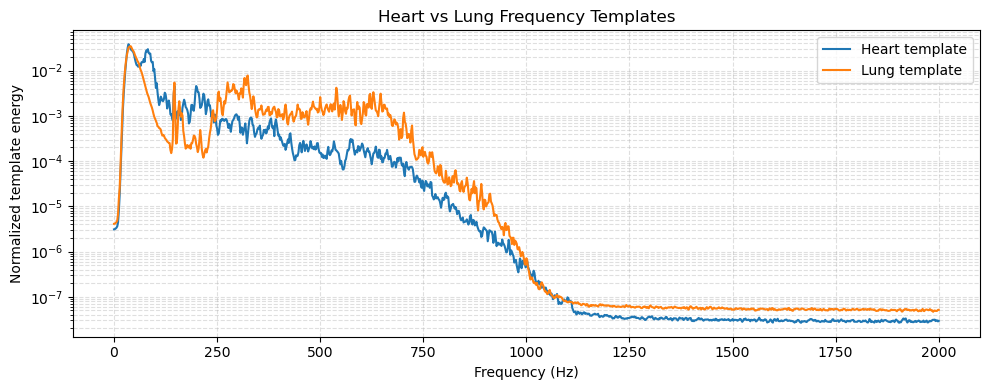

In [4]:
heart_template, lung_template, freqs = build_heart_lung_templates(
    heart_df=datasets["heart_data"],
    lung_df=datasets["lung_data"],
    n_fft=2048,
    hop_length=None,        
    power=2.0,
    max_files_per_source=None, 
)

print("Template length:", len(heart_template))
print("Frequency axis length:", len(freqs))

# Plot templates to inspect where heart vs lung energy lives
plt.figure(figsize=(10, 4))
plt.semilogy(freqs, heart_template, label="Heart template")
plt.semilogy(freqs, lung_template, label="Lung template")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized template energy")
plt.title("Heart vs Lung Frequency Templates")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [5]:
# Pick an example mixture
example_row = datasets["mixed_data"].iloc[0]
print(example_row[["mixed_sound_id", "gender", "heart_sound_type", "lung_sound_type", "location"]])

mix_path = example_row["mixture_file"]
heart_ref_path = example_row["heart_ref_file"]
lung_ref_path = example_row["lung_ref_file"]

mix_sr, mix_audio = load_audio(mix_path, normalize=True)
heart_sr, heart_ref = load_audio(heart_ref_path, normalize=True)
lung_sr, lung_ref = load_audio(lung_ref_path, normalize=True)

print("Sample rates:", mix_sr, heart_sr, lung_sr)

# Run template-based separation
sep_result = separate_mixture_from_audio(
    audio_mix=mix_audio,
    sr=mix_sr,
    heart_template=heart_template,
    lung_template=lung_template,
    n_fft=2048,
    hop_length=None,
    power=2.0,
)


mixed_sound_id                     M0001
gender                                 F
heart_sound_type    Late Systolic Murmur
lung_sound_type                  Rhonchi
location                            LUSB
Name: 0, dtype: object
Sample rates: 4000 4000 4000


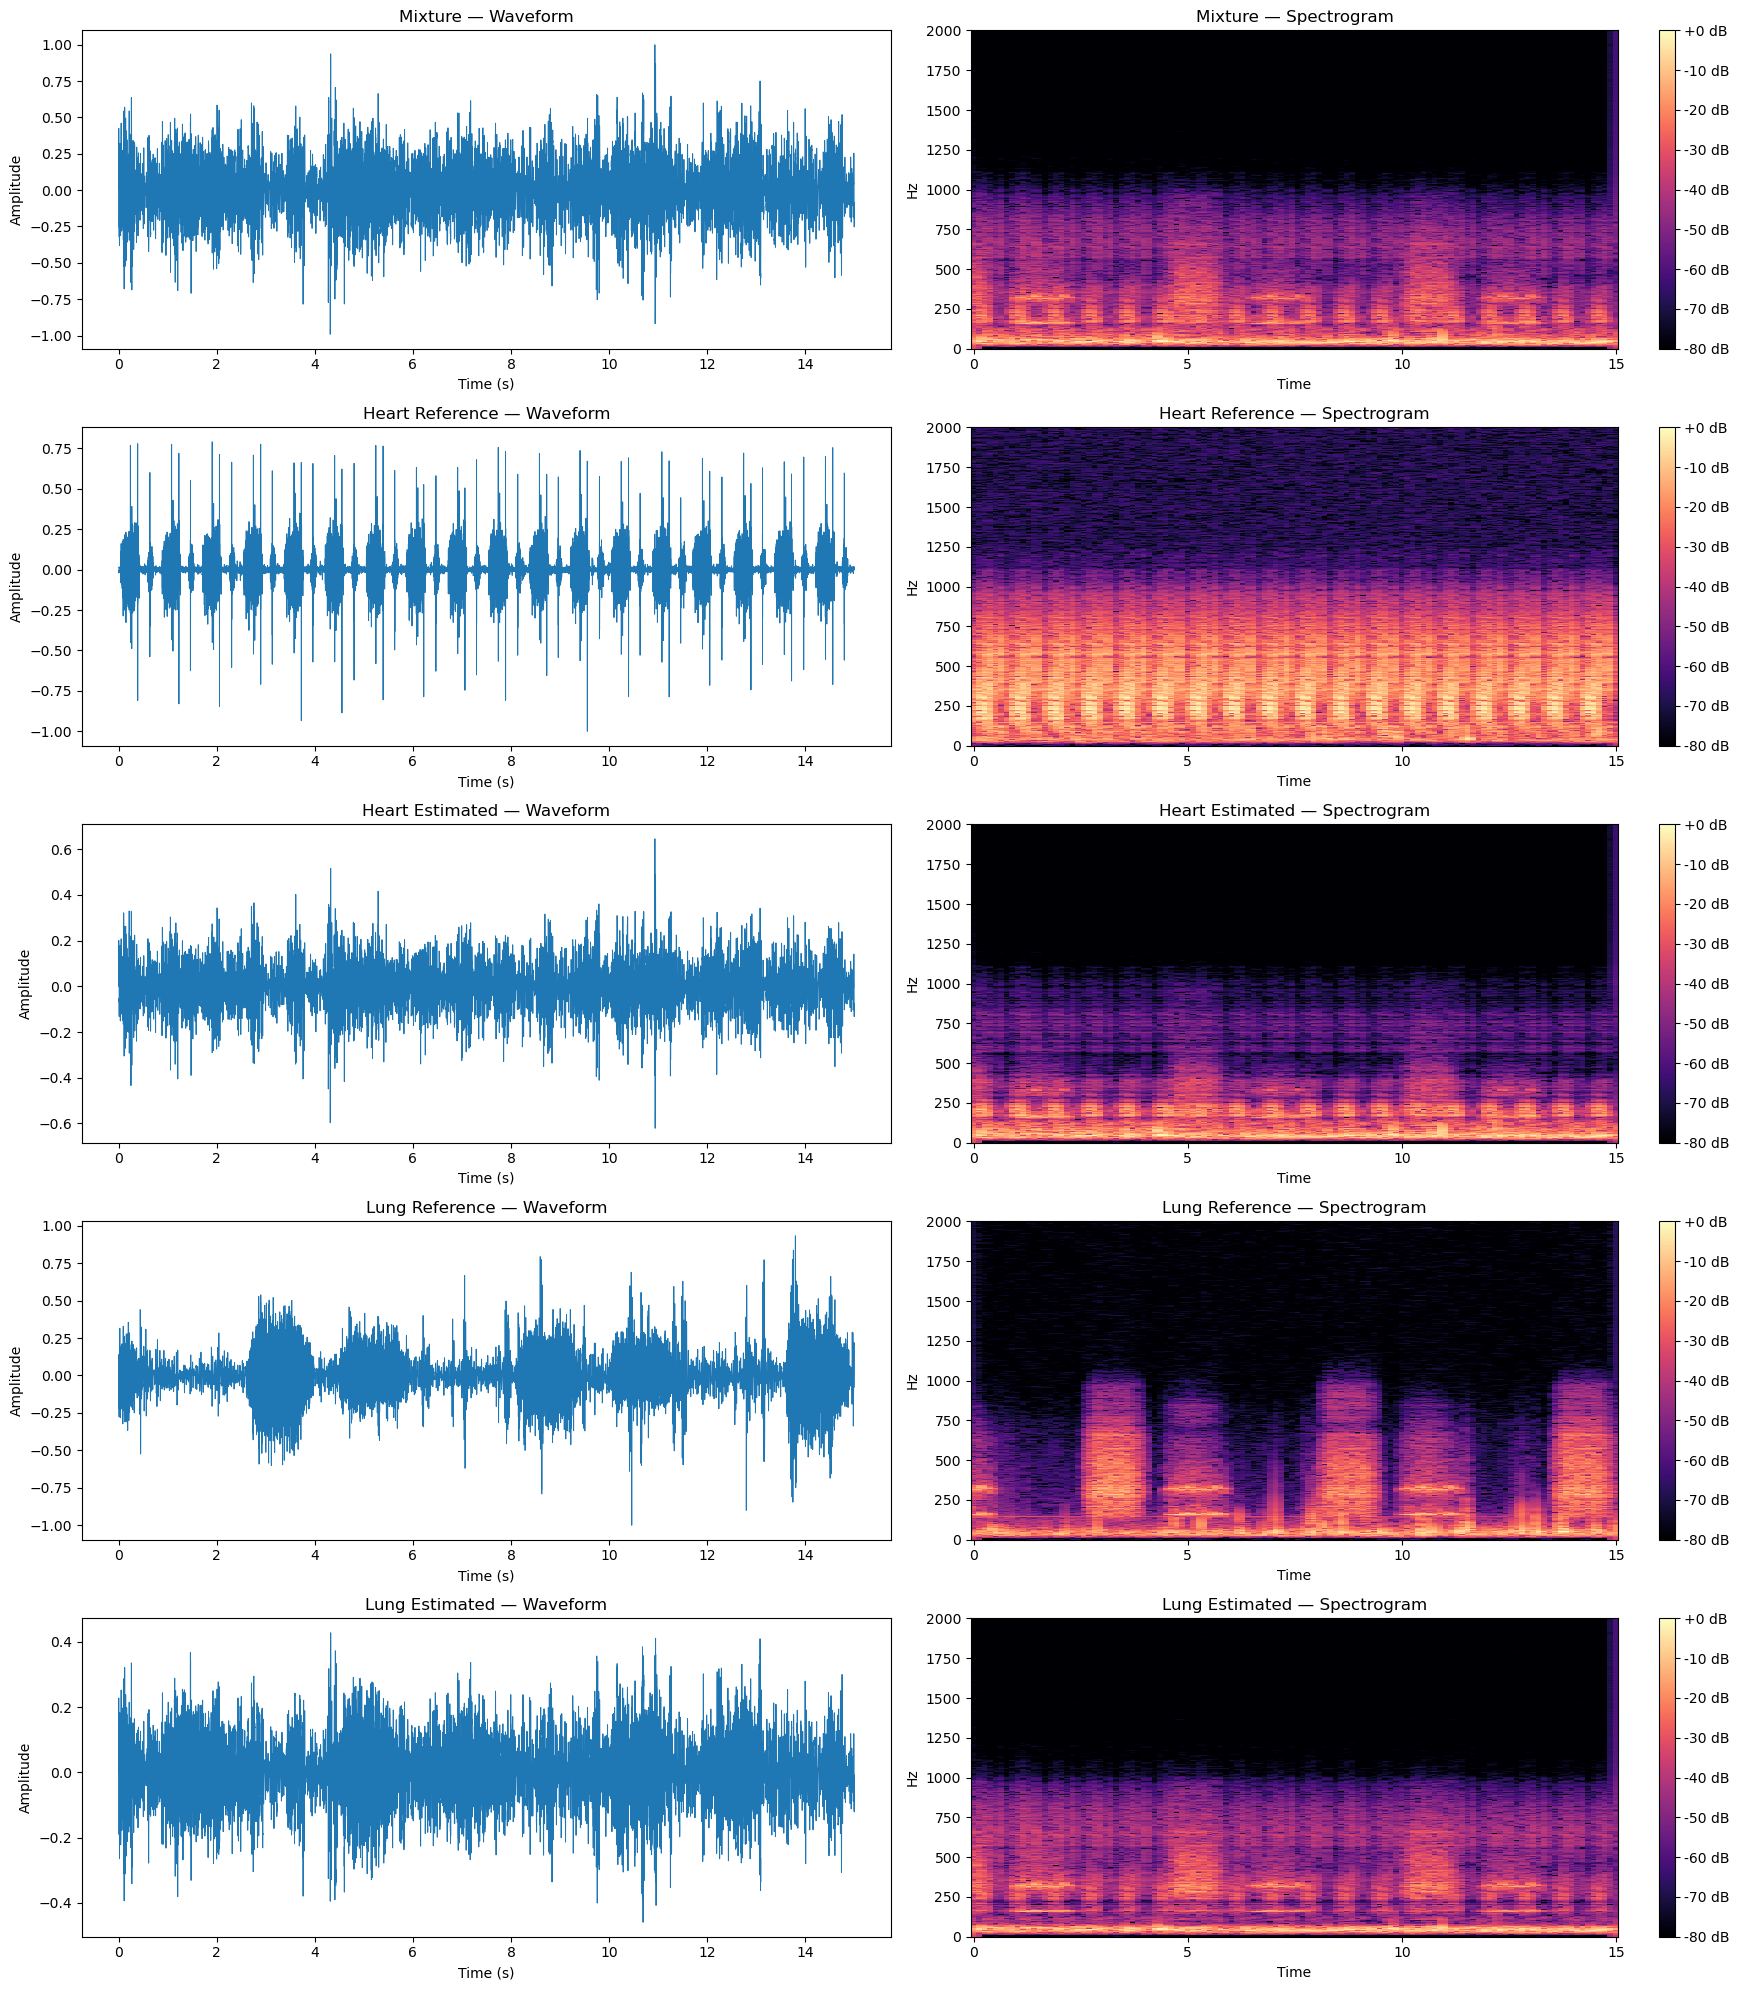

In [6]:
def compute_spec(x, sr, n_fft=2048):
    S = librosa.stft(x, n_fft=n_fft)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    return S_db

signals = [
    ("Mixture", mix_audio),
    ("Heart Reference", heart_ref),
    ("Heart Estimated", sep_result.heart_est),
    ("Lung Reference", lung_ref),
    ("Lung Estimated", sep_result.lung_est)
]

fig, axes = plt.subplots(5, 2, figsize=(18, 20))

for i, (title, audio) in enumerate(signals):
    # ---------- Waveform ----------
    ax_w = axes[i, 0]
    t = np.linspace(0, len(audio)/mix_sr, len(audio))
    ax_w.plot(t, audio, linewidth=0.7)
    ax_w.set_title(f"{title} — Waveform")
    ax_w.set_xlabel("Time (s)")
    ax_w.set_ylabel("Amplitude")

    # ---------- Spectrogram ----------
    ax_s = axes[i, 2-1]  # second column
    S_db = compute_spec(audio, mix_sr)
    img = librosa.display.specshow(
        S_db,
        sr=mix_sr,
        x_axis="time",
        y_axis="hz",
        cmap="magma",
        ax=ax_s
    )
    ax_s.set_title(f"{title} — Spectrogram")
    fig.colorbar(img, ax=ax_s, format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [7]:
results_df = evaluate_over_dataframe(
    mix_df=datasets["mixed_data"],
    heart_template=heart_template,
    lung_template=lung_template,
    n_fft=2048,
    hop_length=None,
    power=2.0,
    max_rows=None,      # set to e.g. 50 if you want a quick sanity check first
    verbose_every=20,
)

results_df.describe()[[
    "waveform_mse_heart", "waveform_mse_lung",
    "waveform_corr_heart", "waveform_corr_lung",
    "waveform_r2_heart", "waveform_r2_lung",
    "spectrogram_mse_heart", "spectrogram_mse_lung"
]]


,waveform_mse_heart,waveform_mse_lung,waveform_corr_heart,waveform_corr_lung,waveform_r2_heart,waveform_r2_lung,spectrogram_mse_heart,spectrogram_mse_lung
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,0.012289,0.013960,0.186252,0.162261,-0.701103,-0.652891,7622.920849,14302.368515
std,0.007956,0.010705,0.344701,0.303592,1.953598,1.563603,9942.394317,28105.036095
min,0.000146,0.000583,-0.214430,-0.057660,-17.967329,-10.865444,34.777679,196.733795
25%,0.005864,0.006035,-0.005154,-0.003084,-0.778241,-0.748445,1910.488525,1755.514038
50%,0.011625,0.011498,0.007482,0.006187,-0.319319,-0.351315,4927.520020,4462.996094
75%,0.017359,0.018653,0.153953,0.058616,-0.017647,-0.057083,8768.731445,11638.000000
max,0.032987,0.055618,0.982767,0.933741,0.866607,0.714718,62478.585938,165210.734375


## NMF Separation

In [9]:
mix_df = datasets["mixed_data"] 
results = []

for idx, row in mix_df.iterrows():

    sr, mix_audio = load_audio(row["mixture_file"], normalize=True)
    _, heart_ref = load_audio(row["heart_ref_file"], normalize=True)
    _, lung_ref  = load_audio(row["lung_ref_file"], normalize=True)

    sep = em_nmf_separate(
        mix_audio, sr,
        heart_template=heart_template,
        lung_template=lung_template,
        n_fft=2048,
        n_iter=60,
    )

    results.append({
        "id": row["mixed_sound_id"],

        "mse_heart": mse(heart_ref, sep.heart_est),
        "mse_lung": mse(lung_ref, sep.lung_est),

        "corr_heart": corr(heart_ref, sep.heart_est),
        "corr_lung": corr(lung_ref, sep.lung_est),

        "r2_heart": r2(heart_ref, sep.heart_est),
        "r2_lung": r2(lung_ref, sep.lung_est),

        "spec_mse_heart": spec_mse(heart_ref, sep.heart_est, sr),
        "spec_mse_lung": spec_mse(lung_ref, sep.lung_est, sr),
    })

results_df = pd.DataFrame(results)
results_df.describe()

,mse_heart,mse_lung,corr_heart,corr_lung,r2_heart,r2_lung,spec_mse_heart,spec_mse_lung
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,0.014395,0.014032,0.175745,0.136958,-1.223312,-0.666636,10285.248102,15113.279281
std,0.009231,0.010336,0.334559,0.261701,3.937556,1.387032,11481.249453,28460.166964
min,0.000087,0.000997,-0.200689,-0.034765,-42.713585,-10.408980,2.002374,126.885368
25%,0.006557,0.006471,-0.005556,-0.002636,-1.187609,-0.751430,2385.108398,2129.355713
50%,0.013619,0.011126,0.008135,0.004587,-0.520579,-0.327628,6990.574219,5355.026367
75%,0.020864,0.019518,0.145307,0.040103,-0.045085,-0.032351,13381.775391,12469.050781
max,0.037947,0.053920,0.966958,0.971787,0.923655,0.658075,63332.574219,165636.734375


### NMF + HMM Smoothing

In [10]:
mix_df = datasets["mixed_data"]

results = []

for idx, row in mix_df.iterrows():

    sr, mix_audio = load_audio(row["mixture_file"], normalize=True)
    _, heart_ref = load_audio(row["heart_ref_file"], normalize=True)
    _, lung_ref  = load_audio(row["lung_ref_file"], normalize=True)

    sep = em_nmf_hmm_separate(
        mix_audio, sr,
        heart_template=heart_template,
        lung_template=lung_template,
        n_fft=2048,
        n_iter=60,
        p_stay=0.99,
    )

    results.append({
        "id": row["mixed_sound_id"],

        "mse_heart": mse(heart_ref, sep.heart_est),
        "mse_lung": mse(lung_ref, sep.lung_est),

        "corr_heart": corr(heart_ref, sep.heart_est),
        "corr_lung": corr(lung_ref, sep.lung_est),

        "r2_heart": r2(heart_ref, sep.heart_est),
        "r2_lung": r2(lung_ref, sep.lung_est),

        "spec_mse_heart": spec_mse(heart_ref, sep.heart_est, sr),
        "spec_mse_lung": spec_mse(lung_ref, sep.lung_est, sr),
    })

results_df = pd.DataFrame(results)
results_df.describe()

,mse_heart,mse_lung,corr_heart,corr_lung,r2_heart,r2_lung,spec_mse_heart,spec_mse_lung
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,0.014600,0.015388,0.160800,0.118167,-1.209689,-0.950761,11391.720536,16078.949254
std,0.009704,0.010844,0.309988,0.229916,4.452844,1.806360,12936.962336,28827.207552
min,0.000120,0.000947,-0.152867,-0.044890,-50.719658,-13.219861,1.821589,269.313538
25%,0.006714,0.007485,-0.004306,-0.001623,-1.055159,-1.058408,2977.273193,2750.053223
50%,0.013665,0.011783,0.007919,0.006152,-0.459774,-0.405056,6987.698242,5789.261230
75%,0.020641,0.020137,0.108112,0.031047,-0.053560,-0.075870,14452.513672,14727.691406
max,0.037862,0.054989,0.935495,0.882397,0.874374,0.488124,61631.933594,164928.812500


### NMF Grid Searching

In [11]:
Ks = [2, 3, 4, 5, 6]    # grid search values
grid_results = []

for K in Ks:
    print(f"Evaluating K={K}...")
    rows = []

    for idx, row in datasets["mixed_data"].iterrows():
        sr, mix_audio = load_audio(row["mixture_file"], normalize=True)
        _, heart_ref = load_audio(row["heart_ref_file"], normalize=True)
        _, lung_ref  = load_audio(row["lung_ref_file"], normalize=True)

        heart_est, lung_est = em_nmf_k_components(
            mix_audio, sr,
            heart_template, lung_template,
            K=K,
            n_fft=2048,
            n_iter=60,
        )

        rows.append({
            "K": K,
            "mse_heart": mse(heart_ref, heart_est),
            "mse_lung": mse(lung_ref, lung_est),
            "corr_heart": corr(heart_ref, heart_est),
            "corr_lung": corr(lung_ref, lung_est),
            "r2_heart": r2(heart_ref, heart_est),
            "r2_lung": r2(lung_ref, lung_est),
            "spec_mse_heart": spec_mse(heart_ref, heart_est, sr),
            "spec_mse_lung": spec_mse(lung_ref, lung_est, sr),
        })

    dfK = pd.DataFrame(rows)
    grid_results.append(dfK)

grid_df = pd.concat(grid_results, ignore_index=True)
grid_df.groupby("K").mean()[[
    "corr_heart", "corr_lung", "r2_heart", "r2_lung"
]]


Evaluating K=2...
Evaluating K=3...
Evaluating K=4...
Evaluating K=5...
Evaluating K=6...


,corr_heart,corr_lung,r2_heart,r2_lung
K,,,,
2,0.157345,0.127955,-1.046181,-1.062333
3,0.157638,0.129719,-0.847962,-1.110970
4,0.164773,0.138026,-0.803010,-1.130489
5,0.168720,0.141275,-0.725815,-1.084115
6,0.161898,0.144276,-0.687345,-1.068709


## U-net reconstruction

Bugged code that's not worthwhile to fix! Check notebooks/outputs/source_reconstruction to see results

In [ ]:
# from reconstruction.deep_learning import (
#     HeartUNet
# )

# ## Train model
# model, losses = train_heart_predictor(
#     df,
#     epochs=5,
#     batch_size=4,
#     lr=1e-3,
#     segment_len=65536,
# )

# model = model.to("cpu")

# # Save model
# save_path = "model_weights/heart_unet.pth"
# torch.save(model.state_dict(), save_path)
# print("Model saved to:", save_path)

# ## Load model
# model = HeartUNet()
# save_path = "model_weights/heart_unet.pth"
# model.load_state_dict(torch.load(save_path, map_location="cpu"))
# model.eval()

# print("Model loaded successfully.")

# plt.figure(figsize=(8,4))
# plt.plot(losses)
# plt.title("Training Loss Curve")
# plt.xlabel("Epoch")
# plt.ylabel("MSE Loss")
# plt.grid(True)
# plt.show()

# results_df = evaluate_full_files(model, df)
# results_df.head()

# print("Mean MSE:", results_df["mse"].mean())
# print("Mean Corr:", results_df["corr"].mean())
# print("Mean R2:", results_df["r2"].mean())

# results_df.describe()

# def plot_comparison(mix, heart_ref, heart_pred, start=0, dur=2000):
#     end = start + dur
#     plt.figure(figsize=(12,4))
#     plt.plot(mix[start:end], label="Mixed", alpha=0.5)
#     plt.plot(heart_ref[start:end], label="Heart Ref", alpha=0.8)
#     plt.plot(heart_pred[start:end], label="Predicted Heart", alpha=0.8)
#     plt.legend()
#     plt.title("Waveform Comparison")
#     plt.show()

# # Grab one example
# row = df.iloc[0]
# sr, mix = load_audio(row["mixture_file"], normalize=True)
# _, heart_ref = load_audio(row["heart_ref_file"], normalize=True)

# # Predict full file
# device = torch.device("cpu")
# model = model.to(device)

# x = torch.tensor(mix, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to("cpu")
# with torch.no_grad():
#     pred = model(x).cpu().numpy()[0,0]

# plot_comparison(mix, heart_ref, pred)